In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"

In [4]:
train_y_dir = '/home/daniel_hung/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_HRnQucRj9uNbbGLMapMO4iJPZws0wd-EGldnD5rPD2wzU.zip/DIV2K_train_HR/'
train_x_dir = '/home/daniel_hung/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_trai_LR8Aa4N_TrUrgpCaoBR45tbRme786TIXlJHQydu3Bt3jo.zip/DIV2K_train_LR_bicubic/X4/'
val_y_dir = '/home/daniel_hung/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_vali_HRIN0x_YTXd7wc9da3ZUo_VpwK7HRFiuCUEirR0EiZAPw.zip/DIV2K_valid_HR/'
val_x_dir = '/home/daniel_hung/tensorflow_datasets/downloads/extracted/ZIP.data.visi.ee.ethz.ch_cvl_DIV2_DIV2_vali_LRpQpdHEuI3k6NMA2PsrkExS_pOyspikiZaXdg18u21VM.zip/DIV2K_valid_LR_bicubic/X4/'

## Preprocessing

## Flip, crop and resize images

In [5]:
def flip_left_right(lr, hr):
    """Flips images to left or right randomly"""
    rn = np.random.uniform()
    return (lr, hr) if rn < 0.5 else (np.fliplr(lr), np.fliplr(hr))
    

In [6]:
def random_rotate(lr, hr):
    """rotate image by 90 degrees randomly"""
    rn = np.random.randint(4)
    return np.rot90(lr, rn), np.rot90(hr, rn)

In [7]:
def random_crop(lr_img, hr_img, hr_crop_size=96, scale=4):
    """Crop images.
    sub-image for larger training data-set
    low resolution images: 24x24
    high resolution images: 96x96
    """
    lr_crop_size = hr_crop_size // scale  # 96//4=24
    lr_img_shape = lr_img.shape[:2]  # (height,width)

    lr_width = np.random.randint(lr_img_shape[1] - lr_crop_size + 1)
    lr_height = np.random.randint(lr_img_shape[0] - lr_crop_size + 1)

    hr_width = lr_width * scale
    hr_height = lr_height * scale
    


    lr_img_cropped = lr_img[
        lr_height : lr_height + lr_crop_size,
        lr_width : lr_width + lr_crop_size,
    ]  # 24x24
    hr_img_cropped = hr_img[
        hr_height : hr_height + hr_crop_size,
        hr_width : hr_width + hr_crop_size,
    ]  # 96x96

    return lr_img_cropped, hr_img_cropped

## Augmentation

In [8]:
# download DIV2K from TF datasets
# using bicubic 4x degradation type
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 lr_img_paths,
                 hr_img_paths,
                 batch_size=32,
                 dim=(None, None, 3),
                 shuffle=True,
                 training=False):
        self.dim = dim
        self.batch_size = batch_size
        self.lr_imgs = glob.glob(os.path.join(lr_img_paths, '*.png'))
        self.hr_imgs = glob.glob(os.path.join(hr_img_paths, '*.png'))
        self.shuffle = shuffle
        self.training = training
        self.img_indexes = np.arange(len(self.lr_imgs))
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_indexes) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temps = [self.img_indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temps)
        return X, y
        
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.lr_imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temps):
        X = []
        y = []
        for i, ID in enumerate(list_IDs_temps):
            lr_img = cv2.cvtColor(cv2.imread(self.lr_imgs[ID]), cv2.COLOR_BGR2RGB).astype(np.float32)
            hr_img = cv2.cvtColor(cv2.imread(self.hr_imgs[ID]), cv2.COLOR_BGR2RGB).astype(np.float32)
            lr_img, hr_img = random_crop(lr_img, hr_img, scale=4)
            if self.training:
                lr_img, hr_img = random_rotate(lr_img, hr_img)
                lr_img, hr_img = flip_left_right(lr_img, hr_img)
            X.append(lr_img)
            y.append(hr_img)
        return np.array(X), np.array(y)

In [9]:
train_ds = DataGenerator(train_x_dir, train_y_dir, shuffle=True, training=True)
val_ds = DataGenerator(val_x_dir, val_y_dir, shuffle=False)

## Visualization

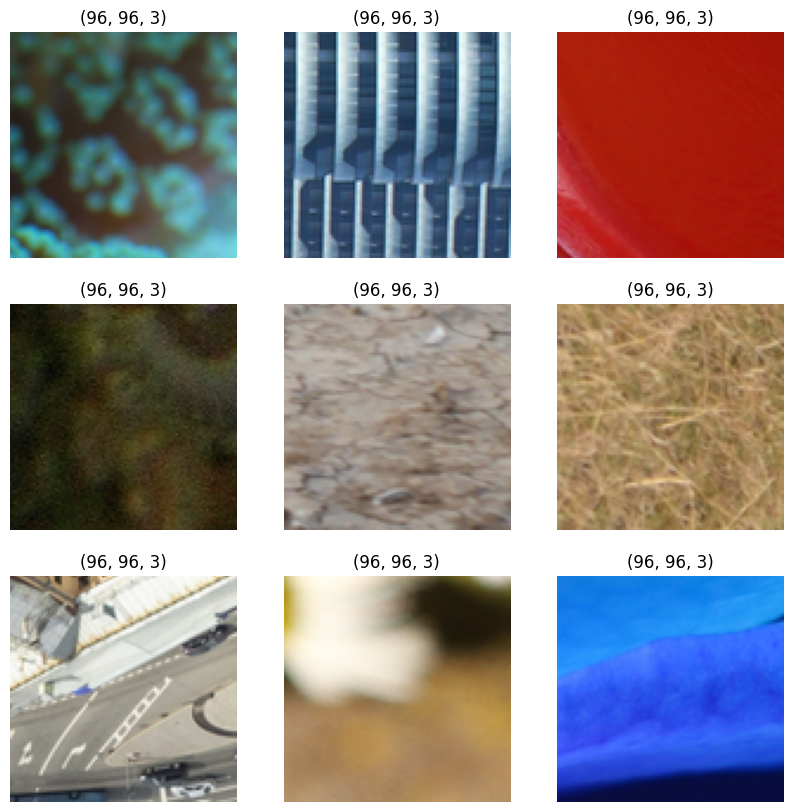

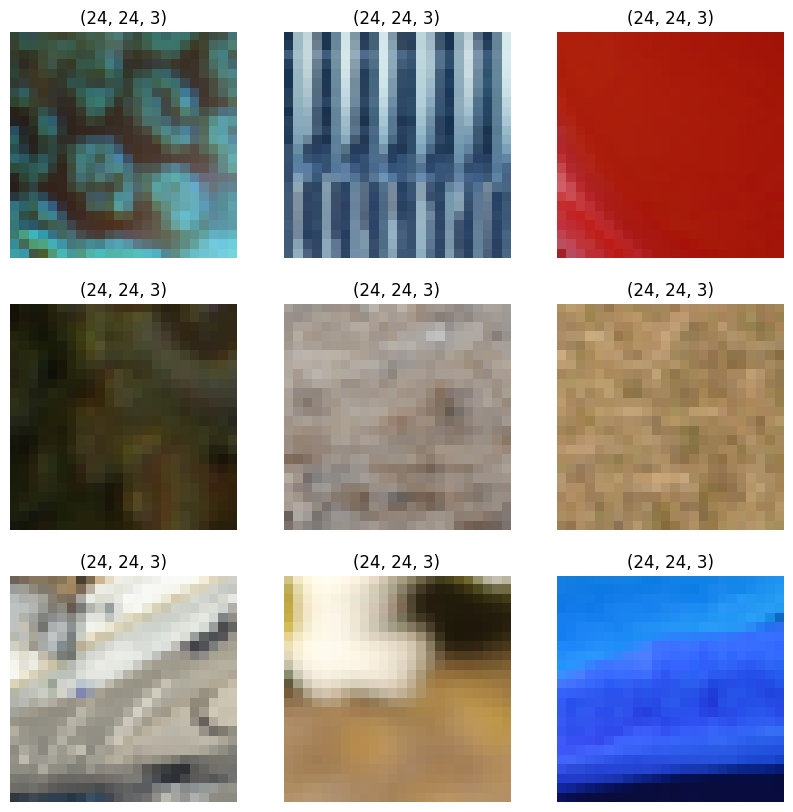

In [10]:
lr, hr = train_ds[0]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(hr[i]).astype("uint8"))
    plt.title(hr[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(lr[i]).astype("uint8"))
    plt.title(lr[i].shape)
    plt.axis("off")

## Metric

In [11]:
def PSNR(sr, hr):
    psnr_value = tf.image.psnr(hr, sr, max_val=255)[0]
    return psnr_value

## Build the model

In [12]:
class EDSR(tf.keras.Model):

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # update metric
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        super_resolution_img = tf.round(super_resolution_img)
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img



In [13]:
# defining some blocks
# residual block
def res_block(inputs):
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.Add()([inputs, x])
    return x

# up-sampling block
def upsampling_block(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding='same', **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor) # sub-pixel convolution, x2 up-sampling
    x = layers.Conv2D(64 * (factor ** 2), 3, padding='same')(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

In [18]:
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3), dtype=np.float32)
    x = tf.cast(input_layer, tf.float32)/255
    x = x_new = keras.layers.Conv2D(num_filters, 3, padding='same')(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = res_block(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding='same')(x_new)
    x = layers.Add()([x, x_new])
    x = upsampling_block(x)
    x = layers.Conv2D(3, 3, padding='same')(x)

    output_layer = x*255
    return EDSR(input_layer, output_layer)


In [19]:
model = make_model(num_filters=64, num_of_residual_blocks=16)

In [20]:
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, None, None,  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, None, None, 6 1792        tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, None, None, 6 36928       conv2d_37[0][0]                  
_______________________________________________________________________________________________

In [21]:
opt = keras.optimizers.Adam(learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    ))
model.compile(optimizer=opt, loss="mae", metrics=[PSNR])
model.fit_generator(train_ds, epochs=100, steps_per_epoch=100, validation_data=val_ds)

Epoch 1/100


ValueError: Boundaries (<dtype: 'int32'>) must have the same dtype as x (<dtype: 'float32'>).